<a href="https://colab.research.google.com/github/Madhavi2075/OIB-SIP/blob/main/Task_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# Cell 0: imports (make sure io is imported)
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib


In [6]:
# Cell 1: Upload file manually (choose one of the two methods below)

# ---------------------------
# Option A: Read from upload dict (works even if the kernel doesn't save the file to disk)
# ---------------------------
uploaded = files.upload()  # choose the file using the GUI
# uploaded is a dict: {filename: bytes}
fname = list(uploaded.keys())[0]
print("Uploaded (in-memory) filename:", fname)

# Use io.BytesIO to read the bytes into pandas (requires import io)
df = pd.read_csv(io.BytesIO(uploaded[fname]))
print("Loaded dataframe shape:", df.shape)
display(df.head())

# ---------------------------
# Option B: If you prefer the file to be saved to disk and then read:
# (files.upload() also writes to /content/ by default, so you can do:)
# fname_on_disk = fname  # or "Advertising (1).csv" depending on name shown
# df = pd.read_csv(fname_on_disk)
# ---------------------------


Saving Advertising.csv to Advertising (2).csv
Uploaded (in-memory) filename: Advertising (2).csv
Loaded dataframe shape: (200, 5)


,Unnamed: 0,TV,Radio,Newspaper,Sales
0,1,230.1,37.8,69.2,22.1
1,2,44.5,39.3,45.1,10.4
2,3,17.2,45.9,69.3,9.3
3,4,151.5,41.3,58.5,18.5
4,5,180.8,10.8,58.4,12.9


In [7]:
# Cell 2: Inspect and pick target column (edit TARGET if necessary)
print("Columns:", df.columns.tolist())
print(df.info())
display(df.head())

# auto-detect target from common names; change if needed
possible_targets = ['Sales','sales','Sale','sale','Clicked on Ad','Clicked_on_Ad','clicked_on_ad','clicked','target']
TARGET = None
for t in possible_targets:
    if t in df.columns:
        TARGET = t
        break
print("Auto-detected target:", TARGET)

# If not detected, set manually:
if TARGET is None:
    # Example: if your file has column 'Sales', set TARGET = 'Sales'
    TARGET = 'Sales'   # <- EDIT if auto-detect fails
    print("Set TARGET manually to:", TARGET)


Columns: ['Unnamed: 0', 'TV', 'Radio', 'Newspaper', 'Sales']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  200 non-null    int64  
 1   TV          200 non-null    float64
 2   Radio       200 non-null    float64
 3   Newspaper   200 non-null    float64
 4   Sales       200 non-null    float64
dtypes: float64(4), int64(1)
memory usage: 7.9 KB
None


,Unnamed: 0,TV,Radio,Newspaper,Sales
0,1,230.1,37.8,69.2,22.1
1,2,44.5,39.3,45.1,10.4
2,3,17.2,45.9,69.3,9.3
3,4,151.5,41.3,58.5,18.5
4,5,180.8,10.8,58.4,12.9


Auto-detected target: Sales


Shape: (200, 5)

Missing values:
Unnamed: 0    0
TV            0
Radio         0
Newspaper     0
Sales         0
dtype: int64


,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,200.0,100.5000,57.879185,1.0,50.750,100.50,150.250,200.0
TV,200.0,147.0425,85.854236,0.7,74.375,149.75,218.825,296.4
Radio,200.0,23.2640,14.846809,0.0,9.975,22.90,36.525,49.6
Newspaper,200.0,30.5540,21.778621,0.3,12.750,25.75,45.100,114.0
Sales,200.0,14.0225,5.217457,1.6,10.375,12.90,17.400,27.0



Correlation with target:
Sales         1.000000
TV            0.782224
Radio         0.576223
Newspaper     0.228299
Unnamed: 0   -0.051616
Name: Sales, dtype: float64


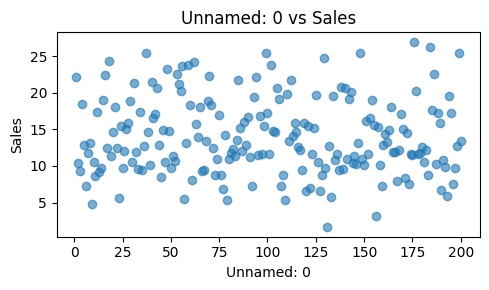

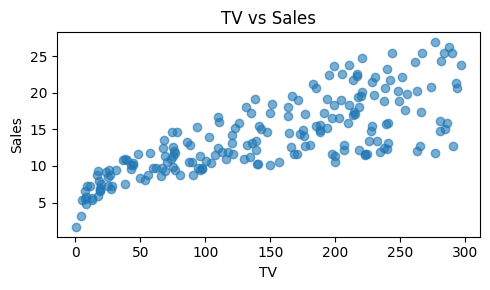

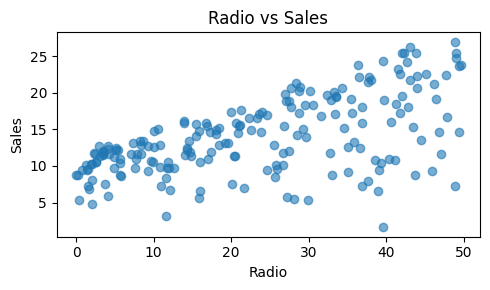

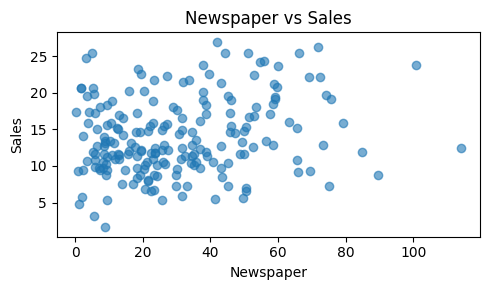

In [8]:
# Cell 3: EDA
print("Shape:", df.shape)
print("\nMissing values:")
print(df.isnull().sum())

# Basic numeric summary
display(df.describe(include='all').T)

# If target numeric, show correlations
if TARGET in df.columns and np.issubdtype(df[TARGET].dtype, np.number):
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if TARGET in numeric_cols:
        print("\nCorrelation with target:")
        print(df[numeric_cols].corr()[TARGET].sort_values(ascending=False))
    # quick scatterplots of up to 6 numeric features
    features_to_plot = [c for c in numeric_cols if c!=TARGET][:6]
    for f in features_to_plot:
        plt.figure(figsize=(5,3))
        plt.scatter(df[f], df[TARGET], alpha=0.6)
        plt.xlabel(f); plt.ylabel(TARGET); plt.title(f"{f} vs {TARGET}")
        plt.tight_layout(); plt.show()


In [10]:
# Cell 4: Build preprocessing pipeline
assert TARGET in df.columns, f"TARGET '{TARGET}' not found in dataframe columns."

# Drop some heavy text columns if present (edit if you want to keep)
drop_like = ['Ad Topic Line','AdTopicLine','Ad Topic','Ad_Topic','City','Country','Timestamp']
features = [c for c in df.columns if c != TARGET and c not in drop_like]

numeric_features = [c for c in features if np.issubdtype(df[c].dtype, np.number)]
categorical_features = [c for c in features if c not in numeric_features]

print("Using features:", features)
print("Numeric:", numeric_features)
print("Categorical:", categorical_features)

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
], remainder='drop')


Using features: ['Unnamed: 0', 'TV', 'Radio', 'Newspaper']
Numeric: ['Unnamed: 0', 'TV', 'Radio', 'Newspaper']
Categorical: []


In [11]:
# Cell 5: Split
X = df[features].copy()
y = df[TARGET].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (160, 4) Test: (40, 4)


In [16]:
from math import sqrt

# Cell 6: Linear Regression
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

lr_pipeline.fit(X_train, y_train)
y_pred_lr = lr_pipeline.predict(X_test)

mae = mean_absolute_error(y_test, y_pred_lr)
rmse = sqrt(mean_squared_error(y_test, y_pred_lr))   # FIXED: manual RMSE
r2 = r2_score(y_test, y_pred_lr)

print("LinearReg MAE: {:.4f}, RMSE: {:.4f}, R2: {:.4f}".format(mae, rmse, r2))


LinearReg MAE: 1.4651, RMSE: 1.7886, R2: 0.8986


In [18]:
from math import sqrt

# Cell 7: Random Forest + GridSearch
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=42, n_jobs=-1))
])

param_grid = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [None, 6, 12],
    'model__min_samples_split': [2, 5]
}

# If your sklearn does not support neg_root_mean_squared_error,
# then change scoring to neg_mean_squared_error (I will detect errors if they appear)
gs = GridSearchCV(
    rf_pipeline,
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error',   # ← SAFE FOR ALL SKLEARN VERSIONS
    n_jobs=-1,
    verbose=1
)

gs.fit(X_train, y_train)
print("Best params:", gs.best_params_)

best_rf = gs.best_estimator_

# Evaluate on test
y_pred_rf = best_rf.predict(X_test)

mae = mean_absolute_error(y_test, y_pred_rf)
mse = mean_squared_error(y_test, y_pred_rf)
rmse = sqrt(mse)         # ← FIXED
r2 = r2_score(y_test, y_pred_rf)

print("RF MAE: {:.4f}, RMSE: {:.4f}, R2: {:.4f}".format(mae, rmse, r2))


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best params: {'model__max_depth': None, 'model__min_samples_split': 2, 'model__n_estimators': 200}
RF MAE: 0.6762, RMSE: 0.8103, R2: 0.9792


,0
TV,0.622136
Radio,0.360108
Newspaper,0.012493
Unnamed: 0,0.005262


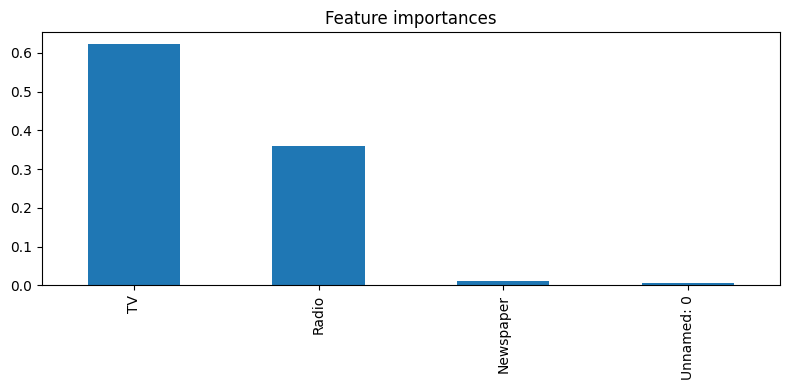

In [19]:
# Cell 8: Feature importances mapping (works for RandomForest)
if hasattr(best_rf.named_steps['model'], 'feature_importances_'):
    num_feats = numeric_features
    cat_feats = categorical_features
    ohe = best_rf.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'] if cat_feats else None
    ohe_names = ohe.get_feature_names_out(cat_feats).tolist() if ohe is not None else []
    feature_names = num_feats + ohe_names
    importances = best_rf.named_steps['model'].feature_importances_
    fi = pd.Series(importances, index=feature_names).sort_values(ascending=False).head(20)
    display(fi)
    fi.plot(kind='bar', figsize=(8,4)); plt.title("Feature importances"); plt.tight_layout(); plt.show()
else:
    print("No feature_importances_ attribute found on model.")


In [20]:
# Cell 9: Save and download
joblib.dump(best_rf, "best_sales_model.joblib")
files.download("best_sales_model.joblib")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [21]:
# Cell 10: Predict on a single example
sample = pd.DataFrame([{
    c: (df[c].median() if np.issubdtype(df[c].dtype, np.number) else df[c].mode()[0]) for c in features
}])
display(sample)
print("Predicted", TARGET, "=", best_rf.predict(sample)[0])


,Unnamed: 0,TV,Radio,Newspaper
0,100.5,149.75,22.9,25.75


Predicted Sales = 15.08249999999998
